In [2]:
import xml.etree.ElementTree as ET
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Returns list of dictionaries containing words and their corresponding references
# The first layer of lists contains individual lines of text 
# The second layer of lists contains individual words in each line of text 
#
# words_arr: 
# [[{word : "And", refs: ["t0", "t1"]} , {word: "He", refs: ["t2", "t3"]}], <- Line 1
#   [{...}, {...}], <- Line 2
#   [{...}, {...}], <- Line 3
# ]
# 
# 
# Also returns a list of line ids which correspond the the lines in the order that they occur 
# lines: ["0", "1", "2", ...]
def read_ink(path):
    tree = ET.parse(path)
    root = tree.getroot()

    traceView = root.find("traceView")

    traceView2 = traceView.findall("traceView")

    textBlockRoots = []

    for t in traceView2:
        annotation = t.find("annotation")

        if (annotation.text == "Textblock"):
            textBlockRoots.append(t)

    words_arr = []
    
    # Array of line tags
    lines = []
    curr_line = 0

    for textBlock in textBlockRoots:
        #For each textline
        for textLine in textBlock.findall("traceView"):
            line_arr = []
            string = textLine[1].text

            lines.append(str(curr_line))
            curr_line += 1

            # For each word in the textline 
            for i in range(2, len(textLine)):
                wordElement = textLine[i]
                word = wordElement[1].text
                
                word_dict = {}

                if word is not None:
                    word_dict["word"] = word
                    word_dict["refs"] = []

                    refs = wordElement.findall('traceView')
                
                    for ref in refs:
                        if 'traceDataRef' in ref.attrib:
                            word_dict["refs"].append(ref.attrib['traceDataRef'])

                    line_arr.append(word_dict)

            words_arr.append(line_arr)

    assert(len(words_arr) == len(lines))                
    return words_arr, lines
    

In [4]:
"9" < "12"

False

In [5]:
for f in glob.glob("../data/datasets/*1*.inkml"):
    print(f)

    textLines, lines = read_ink(f)

    for textLine in textLines:
        for word_dict in textLine:
            print(word_dict["word"], end=" ")
        print()
    print()


../data/datasets/001g.inkml
And he had a feeling - 
thanks to the girl - 
that things would get worse 
before they got better . 
They had the house cleaned 
by noon , and Wilson sent the 
boy out to the meadow to 
bring in the horses . 

../data/datasets/001c.inkml
And he had a feeling - thanks to the girl - 
that things would get worse before they got better . 
They had the 
house cleaned up by 
noon , and Wilson sent 
the boy out to the 
meadow to being in 
the horses . 

../data/datasets/001e.inkml
And he had a feeling - thanks to the girl - 
that things would get worse before 
they got better . They had the house 
cleaned up by noon , and Wilson sent 
the boy out to the meadow to 
bring in the horses 

../data/datasets/001b.inkml
And he had a feeling - thanks to the girl - that things would 
get worse before they get better . They they had the house cleaned 
up by noon , and Wilson sent the boy out to the meadow 
to bring in the horses 

../data/datasets/001a.inkml
And he had a 
fe

In [6]:
# Returns a dict that maps ref id -> digital ink time series
def get_digital_ink(path):
    tree = ET.parse(path)
    root = tree.getroot()
    traces = root.findall("trace")

    digital_ink_dict = {}


    for trace in traces:
        digital_ink_dict[trace.attrib['{http://www.w3.org/XML/1998/namespace}id']] = trace.text

    return digital_ink_dict

In [7]:
def add_value(series, v):
    series.append(series[len(series) - 1] + v)

def add_initial_point(data, x, y, t, p):
    starting_data = data.split(" ")

    start_x = float(starting_data[0])
    start_y = float(starting_data[1])
    start_t = float(starting_data[2])
    start_p = float(starting_data[3])

    x.append(start_x)
    y.append(start_y)
    t.append(start_t)
    p.append(start_p)

In [8]:
# Converts a time series of v,v',v" into a time series of purely v values 
# Basically converts first and second derivatives into normal points
def construct_time_series(raw_time_series):
    raw_time_series = raw_time_series.strip()
    points = raw_time_series.split(",")

    x, y, t, p = [], [], [], []
    
    # Starting data
    if len(points) >= 1:
        add_initial_point(points[0], x, y, t, p)

    # 2nd set of data (1st derivative)
    if len(points) >= 2:
        trace_v = points[1].split("\'")

        v_x = float(trace_v[1])
        v_y = float(trace_v[2])
        v_t = float(trace_v[3])
        v_p = float(trace_v[4])

        add_value(x, v_x)
        add_value(y, v_y)
        add_value(t, v_t)
        add_value(p, v_p)

    # 3rd set of data (2nd derivative)
    if len(points) >= 3:
        trace_acc = points[2].split("\"")

        v_x += float(trace_acc[1])
        v_y += float(trace_acc[2])
        v_t += float(trace_acc[3])
        v_p += float(trace_acc[4]) 

        add_value(x, v_x)
        add_value(y, v_y)
        add_value(t, v_t)
        add_value(p, v_p)

    # for all other sets of data 
    for i in range(3, len(points)):
        values = re.findall("-?\d*\.?\d+", points[i])

        v_x += float(values[0])
        v_y += float(values[1])
        v_t += float(values[2])
        v_p += float(values[3])

        add_value(x, v_x)
        add_value(y, v_y)
        add_value(t, v_t)
        add_value(p, v_p)

    return x, y, t, p  

In [9]:
# Fill time gaps for 1D array with time dimensions as shown below
def get_time_gaps(t):
    time_gaps = np.diff(t)

    start_t = t[0]
    end_t = t[len(t) - 1]

    t_filled = []
    t_filled.append(start_t)
    
    for i in range(0, len(time_gaps)):
        time_gap = time_gaps[i]
        num_intervals = round(time_gap / 0.013)

        if (num_intervals == 0):
            raise Exception("Num Intervals cannot be 0")

        curr_time = t[i]
        next_time = t[i+1]

        if num_intervals != 1:
            for i in range(1, num_intervals):
                t_filled.append(curr_time + 0.013 * i)
        
        t_filled.append(next_time)

    return t_filled        

In [10]:
words_arr = read_ink("../data/datasets/001e.inkml")

In [11]:
ref_dict = get_digital_ink("../data/datasets/001.inkml")

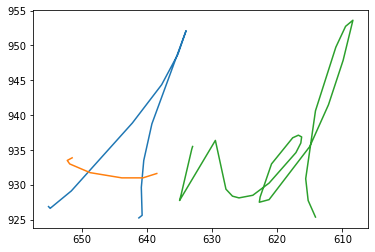

In [12]:
x,y,t,p = construct_time_series(ref_dict['t0'].strip())
t_filled = get_time_gaps(t)
x_filled = np.interp(t_filled, t, x)
y_filled = np.interp(t_filled, t, y)
plt.plot(x_filled,y_filled)
x,y,t,p = construct_time_series(ref_dict['t1'].strip())
t_filled = get_time_gaps(t)
x_filled = np.interp(t_filled, t, x)
y_filled = np.interp(t_filled, t, y)
plt.plot(x_filled,y_filled)
x,y,t,p = construct_time_series(ref_dict['t2'].strip())
t_filled = get_time_gaps(t)
x_filled = np.interp(t_filled, t, x)
y_filled = np.interp(t_filled, t, y)
plt.plot(x_filled,y_filled)
plt.gca().invert_xaxis()
plt.show()